In [1]:
import os
import random
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyBigWig

# Base sequencing depth

In [4]:
# Select cells with WC chr1

chrom = "chr1"

cells = [
    "20220708_GM12878.sc002",
    "20220708_GM12878.sc006",
    "20220708_GM12878.sc010",
    "20220708_GM12878.sc017",
    "20220708_GM12878.sc020",
    "20220708_GM12878.sc022",
    "20220708_GM12878.sc029",
    "20220708_GM12878.sc039",
    "20220708_GM12878.sc042",
    "20220708_GM12878.sc047",
    "20220708_GM12878.sc055",
    "20220708_GM12878.sc066",
    "20220708_GM12878.sc076",
    "20220708_GM12878.sc079",
    "20220708_GM12878.sc087",
]

data = dict()
for cell in cells:
    run = cell.split(".")[0]
    for strand in ["+", "-"]:
        f_bw = "../../1_NanoStrandSeq/results/tracks/all/%s/%s/%s.%s.bw" % (run, cell, cell, strand)
        counter = defaultdict(int)
        f = pyBigWig.open(f_bw)
        length = f.chroms()[chrom]
        for x, y, v in f.intervals(chrom, 0, length):
            counter[v] += (y - x)
        f.close()
        data[(cell, chrom, strand)] = counter

In [5]:
rows = []
for cell in cells:
    counter = defaultdict(int)
    for k, v in data[(cell, chrom, "+")].items():
        if k == 0:
            continue
        counter[min(k, 5)] += v
        
    for k, v in data[(cell, chrom, "-")].items():
        if k == 0:
            continue
        counter[min(k, 5)] += v
    row = [counter[i] for i in range(1, 6)]
    rows.append(row)
d = pd.DataFrame(rows, columns=np.arange(1, 6))
m = d.divide(d.sum(axis=1), axis=0)
ys = m.mean(axis=0)

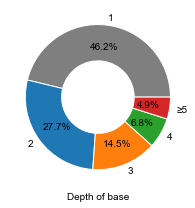

In [7]:
plt.figure(figsize=(4, 3))
plt.pie(ys, labels=["1", "2", "3", "4", "≥5"], normalize=True,
        autopct='%1.1f%%', 
        pctdistance=0.7, 
        colors=["C7", "C0", "C1", "C2", "C3"],
        # textprops=dict(color="white"),
        wedgeprops=dict(width=0.5, edgecolor='w'))
plt.xlabel("Depth of base")
plt.tight_layout()
plt.savefig("figures/base_sequencing_depth.pie.pdf", dpi=300)

# Reads threshold for phasing

In [64]:
# CW

chrom = "chr1"
cells = [
    "20220708_GM12878.sc002",
    "20220708_GM12878.sc006",
    "20220708_GM12878.sc010",
    "20220708_GM12878.sc017",
    "20220708_GM12878.sc020",
    "20220708_GM12878.sc022",
    "20220708_GM12878.sc029",
    "20220708_GM12878.sc039",
    "20220708_GM12878.sc042",
    "20220708_GM12878.sc047",
    "20220708_GM12878.sc055",
    "20220708_GM12878.sc066",
    "20220708_GM12878.sc076",
    "20220708_GM12878.sc079",
    "20220708_GM12878.sc087",
]

chrom = "chr2"
cells = [
    "20220708_GM12878.sc007",
    "20220708_GM12878.sc011",
    "20220708_GM12878.sc012",
    "20220708_GM12878.sc018",
    "20220708_GM12878.sc022",
    "20220708_GM12878.sc023",
    "20220708_GM12878.sc024",
    "20220708_GM12878.sc032",
    "20220708_GM12878.sc035",
    "20220708_GM12878.sc039",
    "20220708_GM12878.sc042",
    "20220708_GM12878.sc044",
    "20220708_GM12878.sc047",
    "20220708_GM12878.sc051",
    #"20220708_GM12878.sc052",
    "20220708_GM12878.sc061",
    # "20220708_GM12878.sc084",
    "20220708_GM12878.sc087",
    "20220708_GM12878.sc088",
    "20220708_GM12878.sc089",
]

data = dict()
rows = []
for cell in cells:
    run = cell.split(".")[0]
    row = []
    for read in range(1, 6):
        path = "../../1_NanoStrandseq/results/stat_hap/%s/%s/%s/summary.%d.tsv" % (run, cell, chrom, read)
        d = pd.read_csv(path, sep="\t", index_col=0)
        m = d.values
        v1 = m[0][0] + m[1][1]
        v2 = m[0][1] + m[1][0]
        if v1 + v2 > 0:
            precision = max(v1, v2) / (v1 + v2)
        else:
            precision = 0
        row.append(precision)
    rows.append(row)

Mean:
0    92.158335
1    99.073569
2    99.409185
3    99.332825
4    99.602174
dtype: float64
Median:
0    92.240289
1    99.200548
2    99.612310
3    99.446042
4    99.753280
dtype: float64


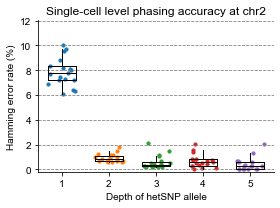

In [65]:
d = pd.DataFrame(rows) * 100
d.index = cells
print("Mean:")
print(d.mean(axis=0))
print("Median:")
print(d.median(axis=0))
vs = [100 - d[c] for c in d.columns]
xs = np.arange(1, len(vs) + 1)
np.random.seed(0)

plt.figure(figsize=(4, 3))
plt.title("Single-cell level phasing accuracy at %s" % chrom)
plt.boxplot(vs, positions=xs, widths=0.6, showfliers=False, showcaps=False, medianprops={"color": "black"})
for x, ys in zip(xs, vs):
    xs1 = np.random.random(len(ys)) * 0.6 - 0.3 + x
    plt.scatter(xs1, ys, marker="o", s=10, clip_on=False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.ylim(-0.2, 12.02)
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.xlabel("Depth of hetSNP allele")
plt.ylabel("Hamming error rate (%)")
#plt.yticks(np.arange(88, 101, 2))
plt.grid(axis="y", ls="--", color="grey")
plt.tight_layout()
plt.savefig("figures/phasing_precision_of_single_cell.%s.pdf" % chrom, dpi=300)